
### Advanced Lane Finding


## Pipeline

* camera calibration
* undistort
* perspective transform
* colorspace thresholding
* gradient thresholding using sobel on x direction, y direction, magnitude and direction.
* Fit a degree 2 polynomial
* Calculate curvature and offset from center

### Step 0 : Import all dependencies

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import cv2
import numpy as np
import os
import pickle

from moviepy.editor import VideoFileClip
from IPython.display import HTML

calibration_path = 'camera_cal/'
test_images_path = 'test_images/'

In [ ]:
%%javascript
//Disable auto scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

## Helper function

This cute little function - `display_stuff()` takes images and labels and display them! With this function, I was able to reduce a lot of code.

In [3]:
def display_stuff(imgs, labels, is_gray=False, figsize=(20,10), fontsize=30):
    '''
    Displays images and labels in a plot
    '''
    f, axes = plt.subplots(1, len(imgs), figsize=figsize)
    for i in range(0,len(imgs)):
        if is_gray:
            axes[i].imshow(imgs[i], cmap='gray')
        else:
            axes[i].imshow(imgs[i])
        axes[i].set_title(labels[i], fontsize=fontsize)
    return axes

### Step 1 : Camera calibration; Find camera matrix, Distortion coefficient

Let's calibrate the camera by using the images in `calibration_path`.

The calibration is done using chessboard images in `camera_cal` folder. Though there are 20 images, I have only used 17 of them as the other three had different `nx` and `ny` than `9` and `6`.

`get_camera_parameters()` returns camera matrix and distortion coefficient by calibrating the camera through `calibrate_camera()`. `get_image_object_points()` gives the 2D(image points) to 3D(object points) points for camera calibration.

NOTE : Camera calibration is a one time job.

Below is the code for camera calibration.

In [4]:
def get_image_object_points(nx=9, ny=6):
    '''
    returns object points(3D) and image points(2D) for calibrtation
    '''
    obj_points = []
    img_points = []
    
    for image_name in os.listdir(calibration_path):
        
        img = mpimg.imread(calibration_path + image_name)
        gray_img =  cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        t_nx, t_ny = nx, ny    
        objp = np.zeros((t_nx*t_ny,3), np.float32)
        objp[:,:2] = np.mgrid[0:t_nx, 0:t_ny].T.reshape(-1,2)
        ret, corners = cv2.findChessboardCorners(gray_img, (t_nx,t_ny), None)
        if ret == True:
            obj_points.append(objp)
            img_points.append(corners)
            img_size = (img.shape[1], img.shape[0])
    return obj_points, img_points, img_size
    
def calibrate_camera():
    '''
    Returns camera matrix, Distortion coefficient and other things for calibrating camera
    '''
    obj_points, img_points, img_size = get_image_object_points(nx=9, ny=6)
    ret, camera_mtx, dist_coefficient, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img_size,None,None)
    return camera_mtx, dist_coefficient, rvecs, tvecs

def get_camera_parameters():
    '''
    Returns camera parameters - camera matrix, distortion coefficient, rotation vector and translational vector.
    '''
    file = "data/camera_params.pickle"
    try:
        pickle_in = open(file,"rb")
        camera_params = pickle.load(pickle_in)
        camera_mtx, dist_coefficient, rvecs, tvecs = camera_params['camera_matrix'], camera_params['distortion_coefficient'],\
                                                     camera_params['rotational_vectors'], camera_params['transational_vectors']
        print("camera parameters loaded from " + file)
    except Exception as error:
        print(error)
        camera_mtx, dist_coefficient, rvecs, tvecs = calibrate_camera()
        camera_params = {'camera_matrix':camera_mtx,
                        'distortion_coefficient':dist_coefficient,
                        'rotational_vectors':rvecs,
                        'transational_vectors':tvecs
                       }
        pickle_out = open(file,"wb")
        pickle.dump(camera_params, pickle_out)
        pickle_out.close()
    return camera_mtx, dist_coefficient, rvecs, tvecs

In [5]:
camera_mtx, dist_coefficient, rvecs, tvecs = get_camera_parameters()

camera parameters loaded from data/camera_params.pickle


### Step 02 : Undistort image

As the name of the step suggests, in this step, we will undistort the image using the camera matrix and distortion coefficients using a function in openCV `cv2.undistort()`. `undistort()` is just a wrapper around `cv2.undistort()`. This step has to be done for all the images which has to be processed. Below is the code.

In [6]:
def undistort(img):
    '''
    Returns undistorted image
    '''
    return cv2.undistort(img, camera_mtx, dist_coefficient, None, camera_mtx)

Let's test whether we got our camera distortion right! For this, we can undistort a chessboard image and see whether it's working.

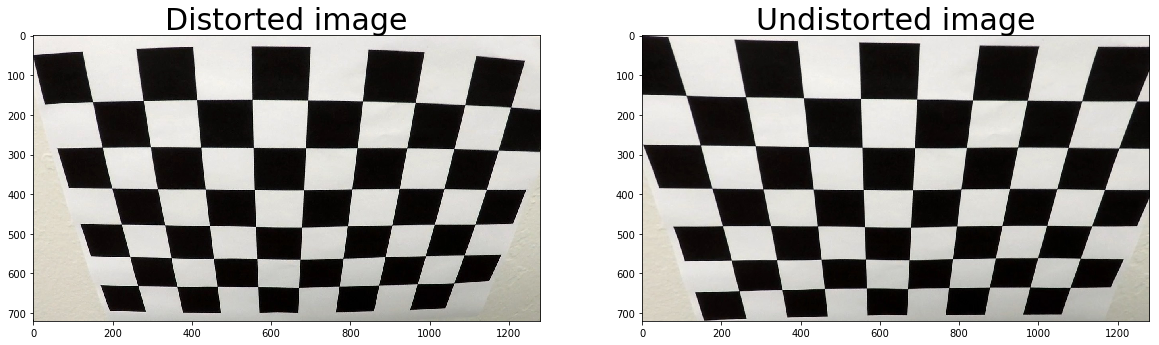

In [7]:
distorted_test_img = plt.imread(calibration_path + 'calibration2.jpg')
undistorted_test_img = undistort(distorted_test_img)

_ = display_stuff([distorted_test_img, undistorted_test_img], ['Distorted image', 'Undistorted image'])

As we can see from above images our `undistort()` does a good job. Thanks to the camera matrix and distortion coefficients that we found in step 1.

### Step 03 : Do prespective transform

Perspective transform is done using a mapping matrix. To find the mapping matrix we need a bunch of source and destination points. These points are given to `cv2.getPerspectiveTransform()` to get the mapping. Once we have the mapping matrix we can use it to transform image using `cv2.warpPerspective()`.

The important thing is to find good source and destination points such as the transformed image has less noise and give us a good top view.

In [8]:
def get_transform_mapping(src, dst):
    '''
    Returns transform matrix and inverse transform matrix for a given source and destination points.
    '''
    mapping = cv2.getPerspectiveTransform(src, dst)
    inverse_mapping = cv2.getPerspectiveTransform(dst, src)
    return mapping, inverse_mapping

def do_transorm(img, mapping):
    '''
    Performs perspective transform on an image for a given transform matrix
    '''
    img_size = (img.shape[1], img.shape[0])
    output = cv2.warpPerspective(img, mapping, img_size, flags=cv2.INTER_LINEAR)
    return output

#### Finding points

Finding good source point is trail and error. But more gap the source point had more noise, transformed image had. So I had to find source points which had a balance between the gap(more gap means more lane info) and noise

![source_points](write_up/assets/source_points.png "source points")

I have found the following source and destination points for finding the transform matrix. The source points I have used is marked green in the above image.

In [9]:
src_points = np.float32([
        [270, 682],
        [567, 469],
        [719, 469],
        [1049, 682]])

dst_points = np.float32([
        [262, 720],
        [262, 0],
        [1045,0],
        [1045,720]
    
    ])

Let's test perspective transform and see the results.

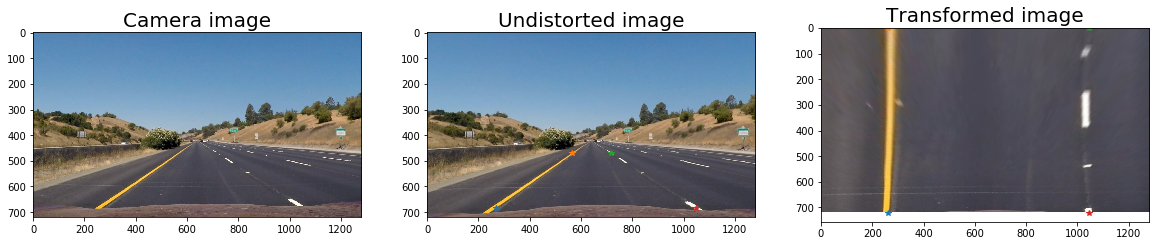

In [10]:
actual_lane_img = plt.imread(test_images_path + 'straight_lines1.jpg')
undistorted_lane_img = undistort(actual_lane_img)
# finding the mappings
mapping, inverse_mapping = get_transform_mapping(src_points, dst_points)
# applying transform
transformed_img =  do_transorm(undistorted_lane_img, mapping)

_, fig2, fig3 = display_stuff([actual_lane_img, undistorted_lane_img, transformed_img], \
                  ['Camera image', 'Undistorted image', 'Transformed image'], fontsize=20)

for x,y in src_points:
    fig2.plot(x, y,'*')
for x,y in dst_points:
    fig3.plot(x, y,'*')


### Step 04 : Color threshold

Instead of relaying on one colorspace, we will be using multiple channels from different colorspaces.

Following channels are used.
* S channel from HLS, with a minimum threshold of 180 and maximum threshold of 255
* B channel from LAB, with a minimum threshold of 155 and maximum threshold of 195
* L channel from LUV, with a minimum threshold of 200 and maximum threshold of 255

### Why?

* S channel of HLS, identifies the white and yellow lane lines. But distracted by shadows.
* B channel of LAB, identifies yellow lane lines. But ignores white lines.
* L channel of LUV, identifies the white lines. But ignores yellow lanes.

In [11]:
def apply_threshold(img, low, high):
    '''
    Applies threshold and returns binary image
    '''
    output = np.zeros_like(img)
    output[(img >= low) & (img <= high)] = 1
    return output

def convert(img, colorspace):
    '''
    Converts an RGB imgae to specified colorspace
    '''
    codecs = {'gray': cv2.COLOR_RGB2GRAY,
              'hls' : cv2.COLOR_RGB2HLS,
              'lab' : cv2.COLOR_RGB2LAB,
              'luv' : cv2.COLOR_RGB2LUV
             }
    return cv2.cvtColor(img, codecs[colorspace.lower()])

def get_channels(img, verbose=False):
    '''
    Returns S, B, L channels from HLS, LAB, LUV colorspaces respectively for img
    '''
    s = convert(img, 'hls')[:,:,2]
    b = convert(img, 'lab')[:,:,2]
    l = convert(img, 'luv')[:,:,0]
    if verbose:
        _ = display_stuff([s_channel, b_channel, l_channel], \
                      ['S Channel, HLS', 'B channel, LAB', 'L channel, LUV'], fontsize=20, is_gray=True)    
    return s,b,l

def get_combined_channels(img, s_thresh=(150,255), b_thresh=(155,195),\
                          l_thresh=(220,255), verbose=False):
    '''
    Returns combined binary image from S, B, L channels from HLS, LAB, LUV
    '''
    s_channel, b_channel, l_channel = get_channels(img)
    s_threshold = apply_threshold(img=s_channel, low=s_thresh[0], high=s_thresh[1])
    b_threshold = apply_threshold(img=b_channel, low=b_thresh[0], high=b_thresh[1])
    l_threshold = apply_threshold(img=l_channel, low=l_thresh[0], high=l_thresh[1])
    
    if verbose:
        _ = display_stuff([s_channel, b_channel, l_channel], \
                      ['S Channel, HLS', 'B channel, LAB', 'L channel, LUV'], fontsize=20, is_gray=True)
        _ = display_stuff([s_threshold, b_threshold, l_threshold], \
                      ['S threshold, HLS', 'B threshold, LAB', 'L threshold, LUV'], fontsize=20, is_gray=True)

    output = np.zeros_like(s_threshold)
    output[(s_threshold == 1) | (b_threshold == 1) | (l_threshold == 1)] = 1
    return output

Let's see the channel information from HLS, LAB and LAB.

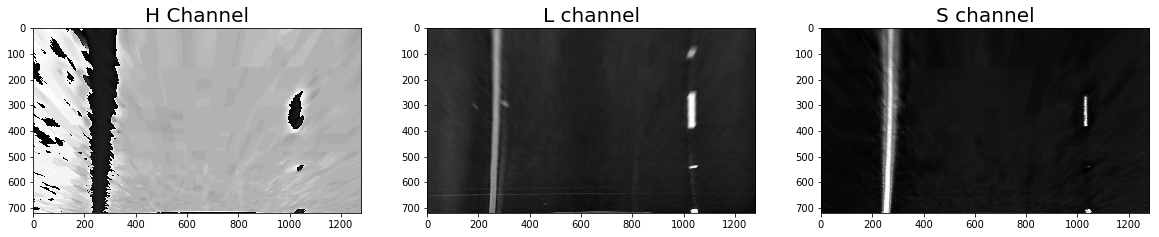

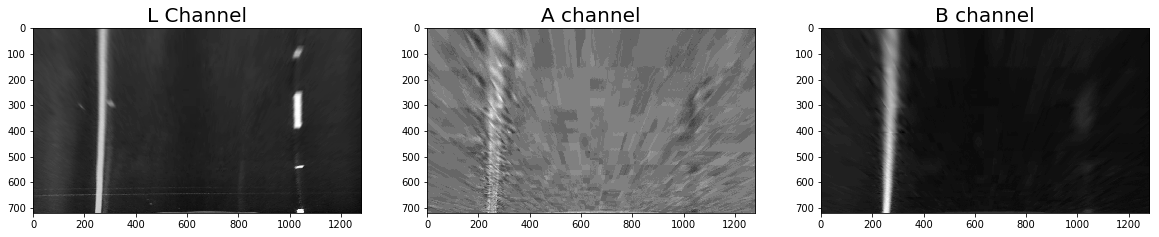

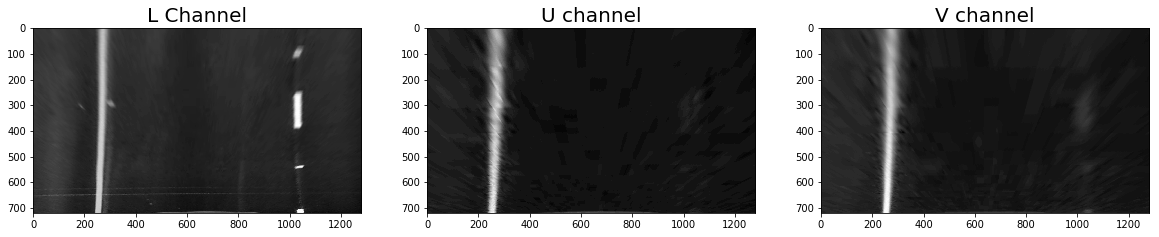

In [12]:
hls_img = convert(transformed_img, 'hls')
lab_img = convert(transformed_img, 'lab')
luv_img = convert(transformed_img, 'luv')

_ = display_stuff([hls_img[:,:,0], hls_img[:,:,1], hls_img[:,:,2]], \
                  ['H Channel', 'L channel', 'S channel'], fontsize=20, is_gray=True)
_ = display_stuff([lab_img[:,:,0], lab_img[:,:,1], lab_img[:,:,2]], \
                  ['L Channel', 'A channel', 'B channel'], fontsize=20, is_gray=True)
_ = display_stuff([luv_img[:,:,0], luv_img[:,:,1], luv_img[:,:,2]], \
                  ['L Channel', 'U channel', 'V channel'], fontsize=20, is_gray=True)

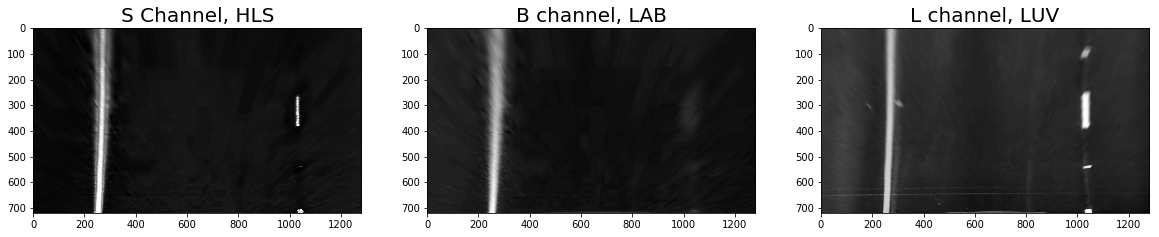

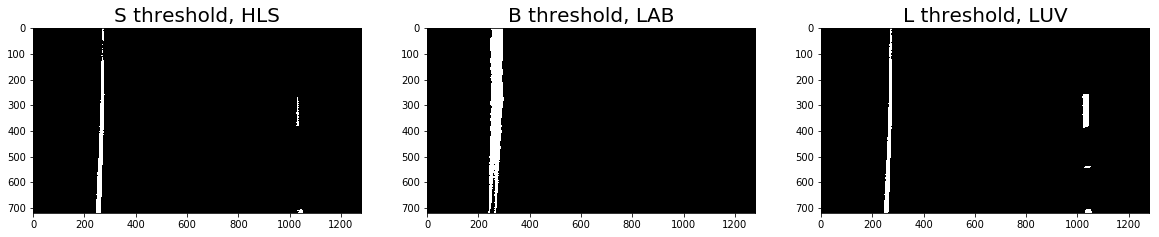

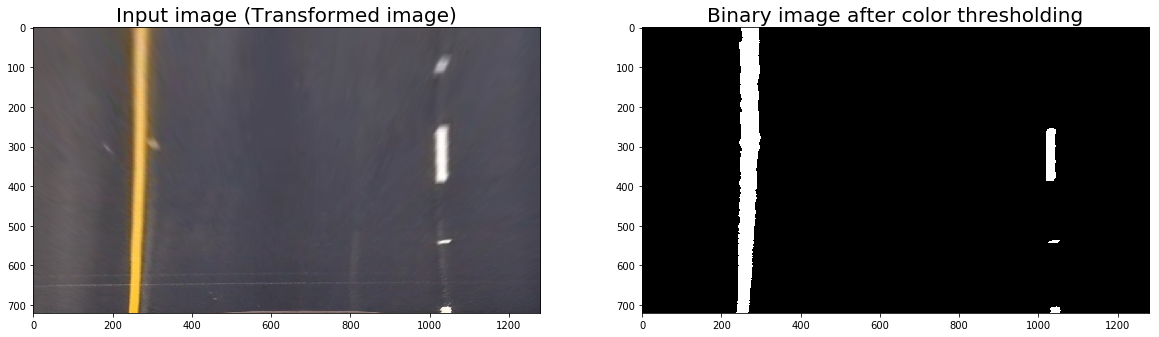

In [13]:
color_binary = get_combined_channels(transformed_img, \
                                     s_thresh=(180,255), b_thresh=(155,195), l_thresh=(200,255), verbose=True)
_ = display_stuff([transformed_img, color_binary], \
                  ['Input image (Transformed image)', 'Binary image after color thresholding'], fontsize=20, is_gray=True)

So, in step 04, I'm combining color channels from different colorspaces. Above is the result of step 05.

### Step 05 : Gradient thresholding

Here, I'm doing sobel operation on x and y direction, gradient magnitude threshold and gradient direction thresholding on the three colorspaces(S from HLS, B from LAB and L from LUV) and combine the results of three together.


#### Thresholds applied:


* For S channel from HLS,
    * Sobel X - low = 30, high = 255
    * Sobel Y - low = 60, high = 255
    * Gradient Magnitude - low = 50, high = 255
    * Direction Magnitude - low = 0, high = 0.56


* For B channel from LAB,
    * Sobel X - low = 40, high = 255
    * Sobel Y - low = 80, high = 255
    * Gradient Magnitude - low = 50, high = 255
    * Direction Magnitude - low = 0, high = 0.56


* For L channel from LUV,
    * Sobel X - low = 40, high = 255
    * Sobel Y - low = 80, high = 255
    * Gradient Magnitude - low = 50, high = 255
    * Direction Magnitude - low = 0, high = 0.56
    

For each channel binary image is created by,
```
((sobelx == 1) & (sobely != 1)) | ((magnitude == 1) & (direction == 1))
```
If a pixel is in sobel x and not in sobel y or a pixel in magnitude and direction is selected.


In [14]:
def absolute_sobel(img, thresh, orient='x', verbose=False):
    '''
    Applies sobel and returns absolute value after applying threshold
    '''
    sobel = cv2.Sobel(img, cv2.CV_64F, int(orient == 'x'), int(orient == 'y'))
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    output = apply_threshold(scaled_sobel, thresh[0], thresh[1])
    if verbose:
        _ = display_stuff([img, scaled_sobel, output], \
                  ['Actual image', 'Sobel ' + orient, 'After threshold'], fontsize=20, is_gray=True)
    return output 

def gradient_magnitude(img, thresh, kernel_size=3, verbose=False):
    '''
    returns gradient magnitude after applying threshold
    '''
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=kernel_size)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    output = apply_threshold(gradmag, thresh[0], thresh[1])
    if verbose:
        _ = display_stuff([img, gradmag, output], \
                  ['Actual image', 'Gradient magnitude', 'After threshold'], fontsize=20, is_gray=True)
    return output

def gradient_direction(img, thresh=(0, np.pi/2), kernel_size=3, verbose=False):
    '''
    returns gradient direction after applying threshold
    '''
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=kernel_size)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    output = apply_threshold(absgraddir, thresh[0], thresh[1])
    if verbose:
        _ = display_stuff([img, absgraddir, output], \
                  ['Actual image', 'Gradient direction', 'After threshold'], fontsize=20, is_gray=True)
    return output

def apply_gradient(img, sobel_x_thresh, sobel_y_thresh, magnitude_thresh, direction_thresh, verbose=False):
    '''
    Returns binary image after applying gradient
    '''
    sobelx = absolute_sobel(img, thresh=sobel_x_thresh, orient='x')
    sobely = absolute_sobel(img, thresh=sobel_y_thresh, orient='y')
    magnitude = gradient_magnitude(img, thresh=magnitude_thresh, kernel_size=15)
    direction = gradient_direction(img, thresh=direction_thresh, kernel_size=15)
    output = np.zeros_like(img)
    output[((sobelx == 1) & (sobely != 1)) | ((magnitude == 1) & (direction == 1))] = 1
    if verbose:
        _ = display_stuff([img, sobelx, sobely, magnitude, direction, output], \
                          ['Actual image', 'Sobel x', 'Sobel y', 'Magnitude', 'Direction', 'output'], fontsize=10, is_gray=True)
    return output

def combine_gradients(s_channel, b_channel, l_channel, verbose=False):
    '''
    Combines the gradient binary images of S channel, B channel and L channel and returns it
    '''
    s_grad = apply_gradient(img=s_channel, sobel_x_thresh=(30,255), \
                        sobel_y_thresh=(60,255), magnitude_thresh=(50,255) , direction_thresh=(0, 0.56))
                                   
    b_grad = apply_gradient(img=b_channel, sobel_x_thresh=(40,255), \
                            sobel_y_thresh=(80,255), magnitude_thresh=(50,255) , direction_thresh=(0, 0.56))

    l_grad = apply_gradient(img=l_channel, sobel_x_thresh=(70,255), \
                            sobel_y_thresh=(140,255), magnitude_thresh=(50,255) , direction_thresh=(0, 0.56))
    
    output = np.zeros_like(s_channel)
    output[(s_grad == 1) | (b_grad == 1) | (l_grad == 1)] = 1
    
    if verbose:
        _ = display_stuff([s_channel, b_channel, l_channel, s_grad, b_grad, l_grad, output], \
                          ['S channel', 'B channel', 'L channel', 'S Gradient combined', 'B Gradient combined',\
                           'L Gradient combined', 'output'],\
                          fontsize=10, is_gray=True)
    return output

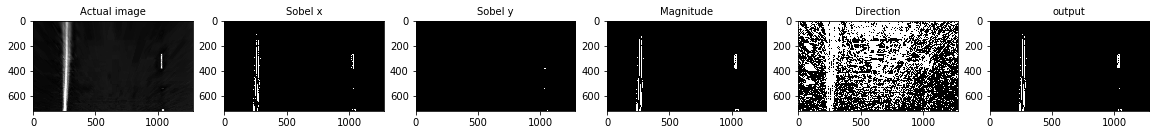

In [15]:
s_channel, b_channel, l_channel = get_channels(transformed_img)
_ = apply_gradient(img=s_channel, sobel_x_thresh=(30,255), \
                        sobel_y_thresh=(60,255), magnitude_thresh=(50,255) , direction_thresh=(0, 0.56), verbose=True)

Above images show how gradient thresholding is done for S channel of HLS.

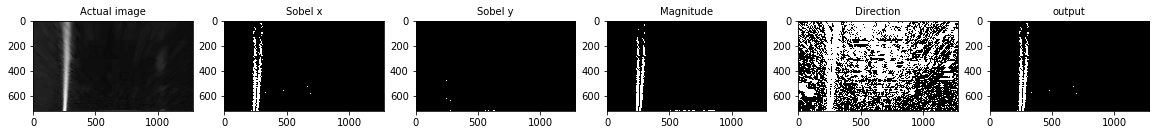

In [16]:
_ = apply_gradient(img=b_channel, sobel_x_thresh=(40,255), \
                        sobel_y_thresh=(80,255), magnitude_thresh=(50,255) , direction_thresh=(0, 0.56), verbose=True)

Above images show how gradient thresholding is done for B channel of LAB.

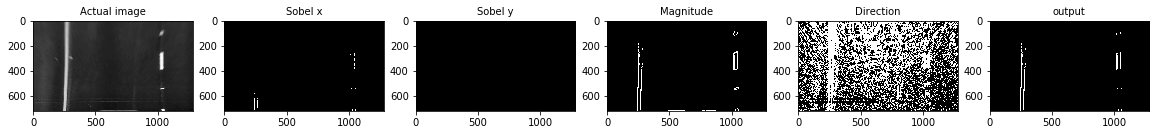

In [17]:
_ = apply_gradient(img=l_channel, sobel_x_thresh=(70,255), \
                        sobel_y_thresh=(140,255), magnitude_thresh=(50,255) , direction_thresh=(0, 0.56), verbose=True)

Above is images show how gradient thresholding is done for L channel of LUV.

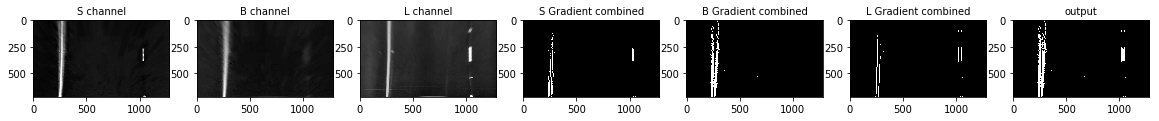

In [18]:
_ = combine_gradients(s_channel, b_channel, l_channel, verbose=True)

Above images show how gradients from diffent color channels are combined and output of `combine_gradients()` which implements step 06.

### Step 06 : Combine color and gradient thresholds

In [19]:
def combine(img, verbose=False):
    '''
    Combines color and gradient threshold output and returns the combined binary image
    '''
    _color_binary = get_combined_channels(img, \
                                     s_thresh=(180,255), b_thresh=(155,195), l_thresh=(200,255))
    
    s_channel, b_channel, l_channel = get_channels(img)
    combined_grad = combine_gradients(s_channel, b_channel, l_channel)
    
    output = np.zeros_like(s_channel)
    output[(_color_binary == 1) & (combined_grad == 1)] = 1
    
    if verbose:
        _ = display_stuff([img, _color_binary, combined_grad, output], \
                          ['Input image', 'Color combined', 'Gradient combined', 'Color and gradient combined'],\
                          fontsize=10, is_gray=True)
    return output

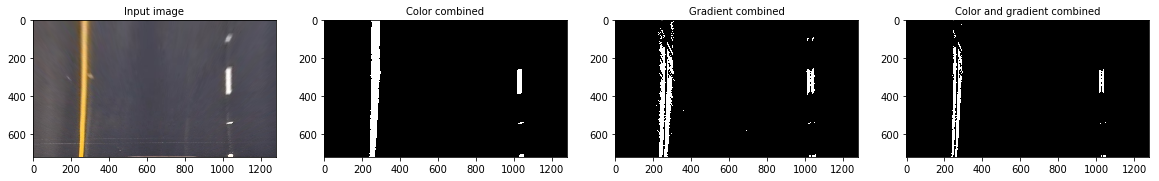

In [20]:
binary_combined = combine(transformed_img, verbose=True)

### Step 07 : Fit degree 2 polynomial

Code for this were given in Udacity classroom. I just refactored it so that I can easily read it.


`get_window_coordinates()` gives window of interest.
`fit_lines()` fits a degree 2 polynomial on lanes using histogram and window technique.

In [21]:
def get_window_coordinates(window_number, center, margin, height, ymax):
    '''
    Gives rectangle coordiantes of vertex and diagonal opposite of the vertex
    '''
    return (center - margin, ymax - (height * (1 + window_number))), (center + margin, ymax - (height * window_number))

In [22]:
def fit_lines(binary_warped, verbose=False):
    '''
    fits a parabola on lane
    '''
    margin = 100
    number_of_windows = 9
    minpix = 50

    left_lane_inds = []
    right_lane_inds = []

    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    histogram = np.sum(binary_warped[:,:], axis=0)

    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint]) #Finding where to start, quite impressive
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    leftx_current = leftx_base # Ha! start position!!
    rightx_current = rightx_base
    
    if verbose:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    ymax = binary_warped.shape[0]
    window_height = np.int(ymax/number_of_windows)
    
    
    nonzeroy, nonzerox = binary_warped.nonzero()
    
    for i in range(0, number_of_windows):
        left_v, left_v1 = get_window_coordinates(window_number=i, center=leftx_current,\
                               margin=margin, height=window_height, ymax=ymax)

        right_v, right_v1 = get_window_coordinates(window_number=i, center=rightx_current,\
                               margin=margin, height=window_height, ymax=ymax)
        
        good_left_inds = ((nonzeroy >= left_v[1]) & (nonzeroy < left_v1[1]) & 
        (nonzerox >= left_v[0]) &  (nonzerox < left_v1[0])).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= right_v[1]) & (nonzeroy < right_v1[1]) & 
        (nonzerox >= right_v[0]) &  (nonzerox < right_v1[0])).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
        if verbose:
            color = (0,255,0)
            thickness = 10
            cv2.rectangle(out_img, left_v, left_v1, color, thickness)
            cv2.rectangle(out_img, right_v, right_v1, color, thickness)

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    y_eval = y_eval = np.max(ploty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # calculating offset
    lane_center = (right_fitx[-1] + left_fitx[-1])/2 
    center_offset_pixels = abs(binary_warped.shape[1]/2 - lane_center)
    center_offset_mtrs = xm_per_pix * center_offset_pixels
    
    if verbose:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        print("left curvature:", left_curverad, 'm,', \
              ", left curvature:",right_curverad, 'm,', 'Offset:', center_offset_mtrs, 'm')
    
    return left_fit, right_fit, left_curverad, right_curverad, center_offset_mtrs

left curvature: 2338.58650922 m, , left curvature: 2834.74711539 m, Offset: 0.0357363695272 m


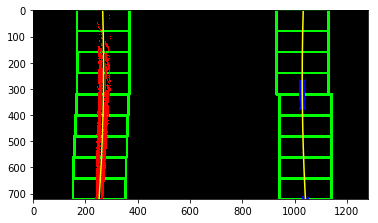

In [23]:
_ = fit_lines(binary_combined, verbose=True)

In [24]:
def paint(actual_image, binary_warped, verbose=False):
    '''
    paints the drivable area in lane
    '''
    left_fit, right_fit, left_curverad, right_curverad, center_offset_mtrs = fit_lines(binary_warped)

    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    newwarp = cv2.warpPerspective(color_warp, inverse_mapping, (actual_image.shape[1], actual_image.shape[0])) 
    result = cv2.addWeighted(actual_image, 1, newwarp, 0.3, 0)
    
    # add curvature
    offset_string = "Center offset: {:.2f} m".format(center_offset_mtrs)
    curvature_string = "Average curvature: {:.2f} m".format((left_curverad + right_curverad)/2)
    cv2.putText(result, curvature_string , (100, 90), cv2.FONT_HERSHEY_TRIPLEX, 2, (255,255,255), thickness=2)
    cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_TRIPLEX, 2, (255,255,255), thickness=2)
    
    if verbose:
        plt.imshow(result)
        plt.show()
    return result

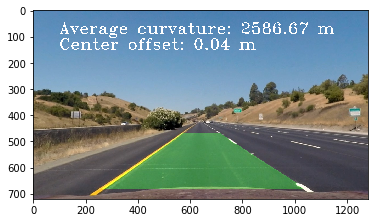

In [25]:
_ = paint(undistorted_lane_img, binary_combined, True)

### Pipeline

In [26]:
mapping, inverse_mapping = get_transform_mapping(src_points, dst_points)
count = 0
def pipeline(img, verbose=False):
    '''
    pipeline that implements the discussed steps
    '''
    undistorted_img = undistort(img)
    
    _transformed_img =  do_transorm(undistorted_img, mapping)
    combined_img = combine(_transformed_img, verbose)
    if verbose:
        plt.show()
    result = paint(undistorted_img, combined_img, verbose)
    return result

#### Pipeline test
Let's test the pipeline using the images in `test_images` folder.

straight_lines1.jpg


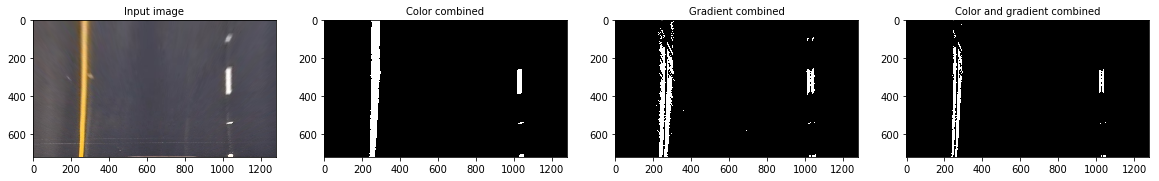

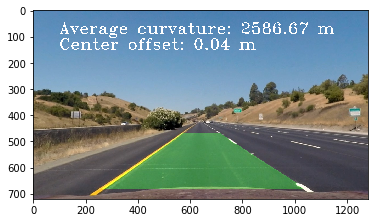

straight_lines2.jpg


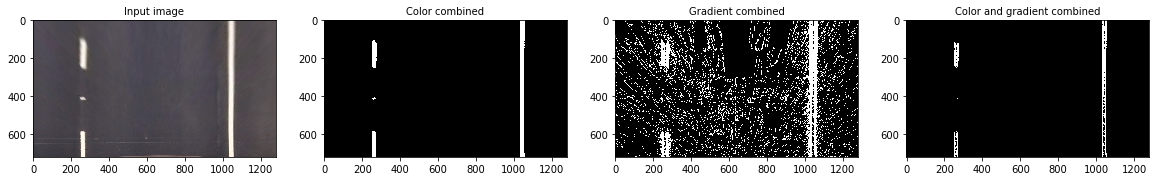

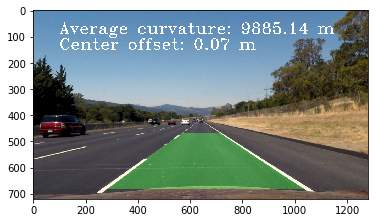

test1.jpg


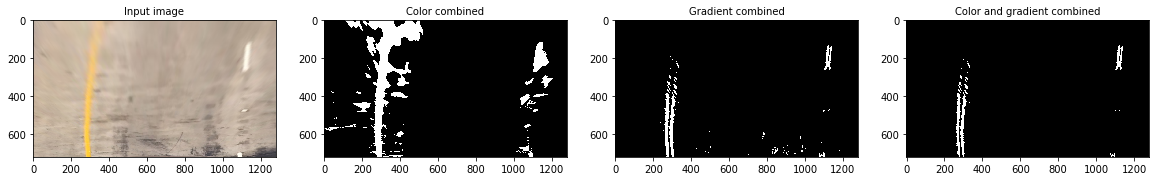

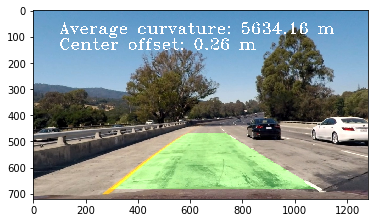

test2.jpg


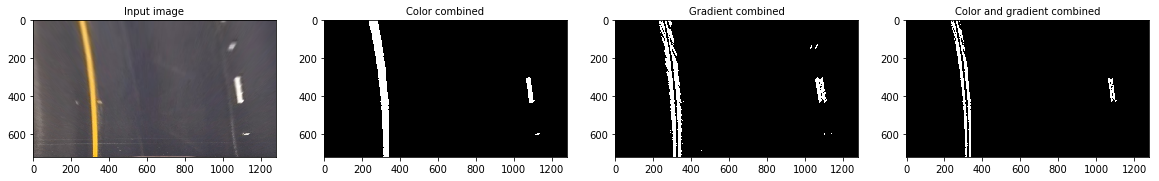

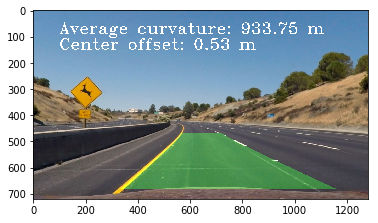

test3.jpg


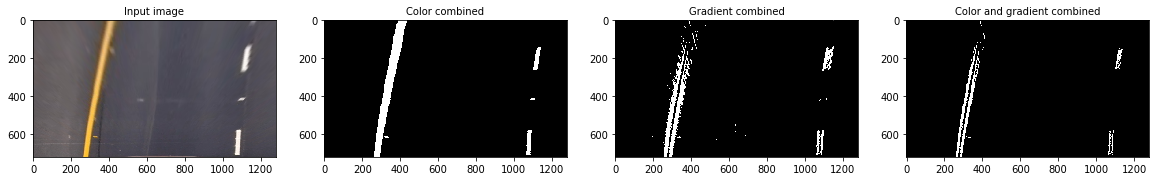

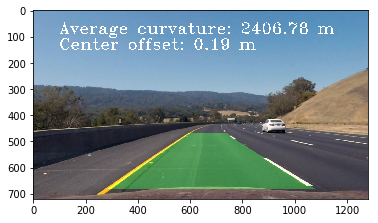

test4.jpg


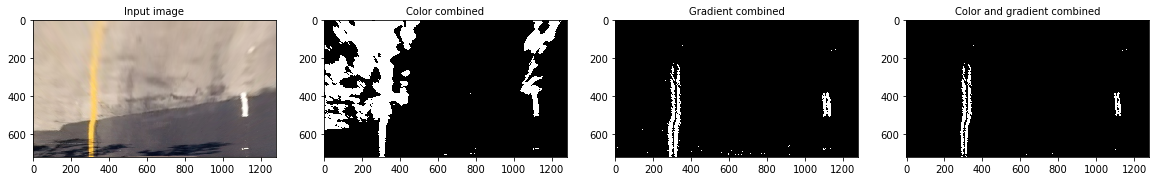

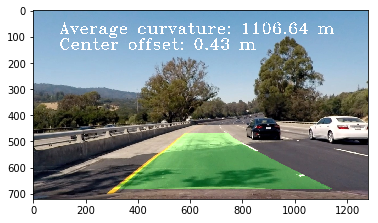

test5.jpg


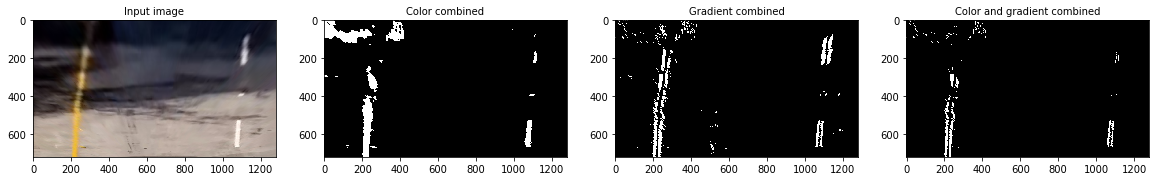

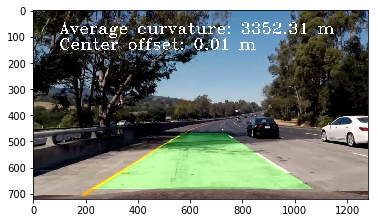

test6.jpg


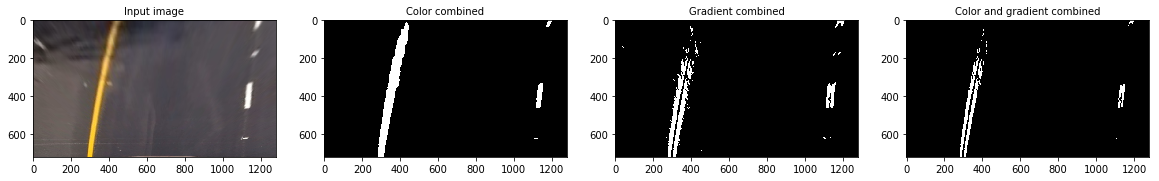

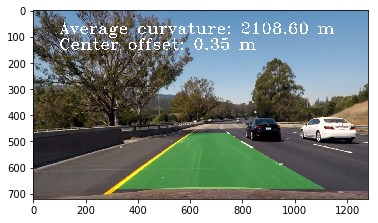

In [27]:
for img_name in os.listdir(test_images_path):
    print(img_name)
    img = plt.imread(test_images_path + img_name)
    _ = pipeline(img, verbose=True)  

### Project video test
Let's test the pipeline on project video

In [28]:
project_video_output = 'assets/project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(41,42)
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video assets/project_video_output.mp4
[MoviePy] Writing video assets/project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [17:48<00:00,  1.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: assets/project_video_output.mp4 

Wall time: 17min 50s


<center>
    <video width="960" height="540" controls src="project_video_output.mp4" />
</center>

## Reflection

* This project has a lot of room for improvement. As we can see, it took 17 minutes to the video, cant be used in realtime scenarios

* I have to explore various ways to detect lanes in `challenge_video.mp4` and `harder_challenge_video.mp4`. One way might be employing RANSAC or CNN based algorithms.


Through this project, I was able to understand various colorspaces, various image processing techniques and I feel more comfortable than ever in image processing using openCV and numpy
